# Prediction

Classification models implement tools for prediction, to get both probabilities (`predict_proba`) and label (`predict`). Both derive the prediction based on the ensemble of local models.

1. For a new location on which you want a prediction, identify local models with a bandwidth used to train the model.
2. Apply the kernel function used to train the model to derive weights of each of the local models.
3. Make prediction using each of the local models in the bandwidth.
4. Make weighted average of prediction based on the kernel weights.
5. Normalize the result to ensure sum of probabilities is 1.

See that in action:

In [9]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics
from sklearn.model_selection import train_test_split

from gwlearn.ensemble import GWRandomForestClassifier

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr")).to_crs(5070)

gdf['point'] = gdf.representative_point()
gdf = gdf.set_geometry('point')

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

Leave out some locations for prediction later.

In [3]:
X_train, X_test, y_train, y_test, geom_train, geom_test = train_test_split(X, y, gdf.geometry, test_size=.1)

Fit the model using the training subset. If you plan to do the prediction, you need to store the local models, which is False by default. When set to True, all the models are kept in memory, so be careful with large datasets. If given a path, all the models will be stored on disk instead, freeing the memory load.

In [4]:
gwrf = GWRandomForestClassifier(
    geometry=geom_train,
    bandwidth=250,
    fixed=False,
    keep_models=True,
)
gwrf.fit(
    X_train,
    y_train,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,553 POI...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None


Now, you can use the test subset to get the prediction. Note that given the prediction is pulled from an ensemble of local models, it is not particularly performant. However, it shall be spatially robust.

In [ ]:
proba = gwrf.predict_proba(X_test, geometry=geom_test)
proba

,False,True
55,0.646070,3.539302e-01
1820,0.951171,4.882939e-02
298,0.981790,1.821050e-02
1243,0.629453,3.705468e-01
1770,0.072114,9.278863e-01
...,...,...
912,0.957101,4.289867e-02
2731,0.853230,1.467700e-01
795,1.000000,3.879098e-07
1224,0.449571,5.504293e-01


You can then check the accuracy of this prediction. Note that similarly to fitting, there might be locations that return NA, if all of the local models within its bandwidth are not fitted.

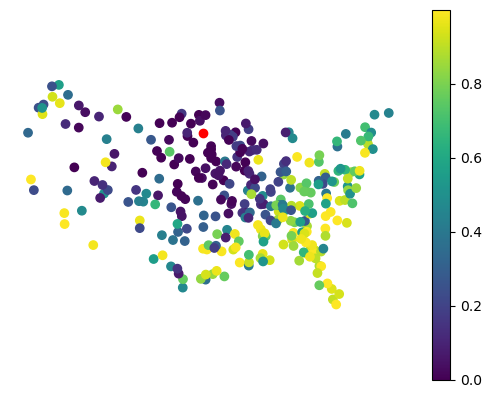

In [ ]:
gpd.GeoDataFrame(proba, geometry=geom_test).plot(True, missing_kwds=dict(color='red')).set_axis_off()

That one red dot, is in the middle of unfittable area.

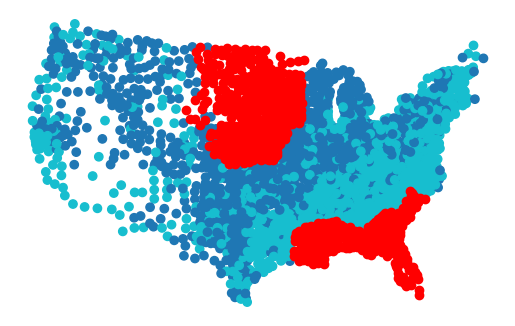

In [27]:
geom_train.to_frame().plot(gwrf.pred_, missing_kwds=dict(color='red')).set_axis_off()

Filter it out and measure the performance on the left-out sample.

In [20]:
na_mask = proba.isna().any(axis=1)

pred = proba[~na_mask].idxmax(axis=1).astype(bool)

metrics.accuracy_score(y_test[~na_mask], pred)

0.801948051948052